In [1]:
import tensorflow as tf
import os
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

## Utils

In [2]:
data_train = '/kaggle/input/dataset-noise-sr/KITTI_unet/training/*'
data_test = '/kaggle/input/dataset-noise-sr/KITTI_unet/training/*'
checkpoint_dir = '/kaggle/working//checkpoint'
buffer_size = 20
batch_size = 2
img_height = 256
img_width = 1024
low_height = 64
low_width = 256
epochs = 150

In [3]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input/dataset-noise-sr'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [4]:
def load(image_path):
    """
    image_lr: input low resolution and noise
    target_lr: target low resolution and not noise 
    target_hr: target high resolution 
    """
    
    # read file and decode image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image)

    # resize image_lr, target_lr with low_width and low_height
    image_lr = tf.image.resize(image, size=(low_height, low_width))
    target_lr = tf.image.resize(image, size=(low_height, low_width))
    
    # resize target_hr IMG_WIDTH and IMG_HEIGHT
    target_hr = tf.image.resize(image, size=(img_height, img_width))
    
    # create noise matrix has size with low_width and low_height
    noise_per = 0.20
    noise = tf.random.uniform(shape=(low_height, low_width, 3), minval=1-noise_per, maxval=1+noise_per)
    
    # Convert image to float32 tensors
    image_lr = tf.cast(image_lr, dtype=tf.float32)
    target_lr = tf.cast(target_lr, dtype=tf.float32)
    target_hr = tf.cast(target_hr, dtype=tf.float32)
    
    # image_lr multiply noise matrix -> noise image
    image_lr = image_lr*noise
    image_lr = tf.clip_by_value(image_lr, 0, 255)
    
    return image_lr, target_lr, target_hr

def normalize(image_lr, target_lr, target_hr):
    """
    normalizing the images to [-1, 1]    

    """
    image_lr  = (image_lr/127.5) - 1  
    target_lr = (target_lr/127.5) - 1 
    target_hr = (target_hr/127.5) - 1 
    
    return image_lr, target_lr, target_hr

#@tf.function()
def random_jitter(image_lr, target_lr, target_hr):
    """
    There is a 50% chance of flipping the image from left to right
    
    """
    if tf.random.uniform(()) > 0.5:
        # random mirroring
        image_lr  = tf.image.flip_left_right(image_lr)
        target_lr  = tf.image.flip_left_right(target_lr)
        target_hr  = tf.image.flip_left_right(target_hr)
        
    return image_lr, target_lr, target_hr
    
def load_image_train(image_path):
    """ 
    load image, random_jitter and normalize image 

    """
    image_lr, target_lr, target_hr = load(image_path)

    image_lr, target_lr, target_hr = random_jitter(image_lr, target_lr, target_hr)

    image_lr, target_lr, target_hr = normalize(image_lr, target_lr, target_hr)

    return image_lr, target_lr, target_hr

def load_image_test(image_path):
    """ 
    load image and normalize image 

    """

    image_lr, target_lr, target_hr = load(image_path)

    image_lr, target_lr, target_hr = normalize(image_lr, target_lr, target_hr)

    return image_lr, target_lr, target_hr


def evaluate(model, epoch, data):        
    psnr_mean = 0.0
    for image_lr, target_lr, target_hr in data:
        fake_lr, fake_hr = model(image_lr, training=False)
        psnr_b = tf.image.psnr(fake_hr, target_hr, max_val=1.0)
        psnr_mean = tf.math.reduce_mean(psnr_b)
    
#     psnr_mean = psnr_mean/10.0
    print('-------- psnr: ', psnr_mean.numpy(), '   ----- epoch: ', epoch)
    return psnr_mean
    

def generate_images(model, image_lr, target_sr, is_fake_lr=False):
    fake_lr, fake_hr = model([image_lr], training=False)
    if is_fake_lr:
        display_list = [image_lr[0], fake_lr[0], target_sr[0], fake_hr[0]]
        title_l = ['Input', 'Denoise', 'Real', 'Generated']    
        plt.figure(figsize=(25,30))
        for i in range(4):
            plt.subplot(1, 4, i+1)
            plt.title(title_l[i])
            plt.imshow(display_list[i] * 0.5 + 0.5)
    else:
        display_list = [image_lr[0], target_sr[0], fake_hr[0]]
        title_l = ['Input', 'Real', 'Generated']    
        plt.figure(figsize=(25,30))
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title_l[i])
            plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.show()

## Models

In [5]:
class SubPixel(layers.Layer):
    def __init__(self, upscale_factor, channels, activation=None):
        super(SubPixel, self).__init__()
        self.upscale_factor = upscale_factor
        self.channels = channels
        self.activation = activation
    
    def __call__(self, inputs):
        x = layers.Conv2D(self.channels*(self.upscale_factor ** 2), 3, padding="same",
                            activation=self.activation, kernel_initializer="Orthogonal")(inputs)
        outputs = tf.nn.depth_to_space(x, self.upscale_factor)
        return outputs

def extract_first_features(filters, size, apply_batchnorm=True):
    result = tf.keras.Sequential()
    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    
    result.add(layers.Conv2D(filters=filters, kernel_size=size, kernel_initializer=initializer,
                        strides=1, padding='same', use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    
    return result
    
def downsample(filters, size, apply_batchnorm=True):
    result = tf.keras.Sequential()
    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    
    result.add(layers.Conv2D(filters=filters, kernel_size=size, kernel_initializer=initializer,
                            strides=2, padding='same', use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())

    result.add(layers.LeakyReLU())
    
    return result

def upsample(filters, size, apply_dropout=False):
    result = tf.keras.Sequential()

    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)

    # Conv2DTranspose stride=2
    result.add(layers.Conv2DTranspose(filters=filters, kernel_size=size, kernel_initializer=initializer,
                            strides=2, padding='same', use_bias=False))
    
    result.add(layers.BatchNormalization())
    
    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())
    
    return result

def downsample_sr(filters, size, apply_batchnorm=True):
    result = tf.keras.Sequential()
    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)

    result.add(layers.Conv2D(filters=filters, kernel_size=size, kernel_initializer=initializer,
                            strides=1, padding='same', use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())

    return result

def upsample_sr(filters, size, apply_dropout=False):
    result = tf.keras.Sequential()

    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)

    # Conv2DTranspose stride=2
    result.add(layers.Conv2DTranspose(filters=filters, kernel_size=size, kernel_initializer=initializer,
                            strides=2, padding='same', use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.LeakyReLU())
    
    return result

In [6]:
def DiscriminatorDenoise():
    # https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_discriminator

    inp = tf.keras.layers.Input(shape=[low_height, low_width, 3])
    tar = tf.keras.layers.Input(shape=[low_height, low_width, 3])
    x = tf.keras.layers.concatenate([inp, tar])
    
    x = downsample(filters=64,  size=4, apply_batchnorm=False)(x)
    x = downsample(filters=128, size=4, apply_batchnorm=True)(x)
    x = downsample(filters=256, size=4, apply_batchnorm=True)(x)
    
    initializer1 =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    initializer2 =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    
    x = layers.Conv2D(filters=256, kernel_size=3, kernel_initializer=initializer1,
                            strides=1, use_bias=False)(x)
    x = layers.Conv2D(filters=1, kernel_size=3, kernel_initializer=initializer2,
                            strides=1, use_bias=False)(x)
    
    model = models.Model(inputs=[inp,tar], outputs=x)
    
    return model
    
def DiscriminatorSR():
    # https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_discriminator

    inp = tf.keras.layers.Input(shape=[img_height, img_width, 3])
    
    x = downsample(filters=64,  size=4, apply_batchnorm=False)(inp)
    x = downsample(filters=128, size=4, apply_batchnorm=True)(x)
    x = downsample(filters=256, size=4, apply_batchnorm=True)(x)
    
    initializer1 =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    initializer2 =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    
    x = layers.Conv2D(filters=256, kernel_size=3, kernel_initializer=initializer1,
                            strides=1, use_bias=False)(x)
    x = layers.Conv2D(filters=1, kernel_size=3, kernel_initializer=initializer2,
                            strides=1, use_bias=False)(x)
    
    model = models.Model(inputs=inp, outputs=x)
    
    return model

In [7]:
def UNet_process(x):
    """
    feature image input -> noise free image

    """
    down_stack = [
        downsample(filters=64, size=4, apply_batchnorm=False),
        downsample(filters=256, size=4, apply_batchnorm=True),
        downsample(filters=512, size=4, apply_batchnorm=True),
        downsample(filters=512, size=4, apply_batchnorm=True),
        downsample(filters=512, size=4, apply_batchnorm=True),
    ]

    up_stack = [
        upsample(filters=512, size=4, apply_dropout=True),
        upsample(filters=512, size=4, apply_dropout=True),
        upsample(filters=256, size=4, apply_dropout=True),
        upsample(filters=64, size=4, apply_dropout=False),
    ]

    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    last = layers.Conv2DTranspose(filters=3, kernel_size=4, kernel_initializer=initializer,
                            strides=2, padding='same', activation='tanh')
    
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)
    
    return x
        
def Generator():
    """
    model denoise and super resolution ((x4 size))

    """
    inputs = layers.Input(shape=(low_height, low_width, 3))
    x = extract_first_features(filters=64, size=3, apply_batchnorm=True)(inputs)
    x = UNet_process(x)
    fake_lr = x

    x = extract_first_features(filters=64, size=3, apply_batchnorm=True)(x)
    x = downsample_sr(filters=256, size=3, apply_batchnorm=True)(x)
    x = downsample_sr(filters=256, size=3, apply_batchnorm=True)(x)

    x = upsample_sr(filters=128, size=4, apply_dropout=False)(x)
    
    x = downsample_sr(filters=128, size=3, apply_batchnorm=True)(x)

    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    last = layers.Conv2DTranspose(filters=3, kernel_size=4, kernel_initializer=initializer,
                            strides=2, padding='same', activation='tanh')
    
    fake_hr = last(x)
    
    model = models.Model(inputs=inputs, outputs=[fake_lr, fake_hr])
    
    return model

## Loss Function

In [8]:
def discriminator_loss(disc_real_output, disc_generated_output):

    loss_dsic_object = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.03)

    real_los = loss_dsic_object(tf.ones_like(disc_real_output), disc_real_output)
    
    fake_los = loss_dsic_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    
    total_loss = real_los + fake_los
    
    return total_loss

def generator_denoise_loss(disc_generated_output, gen_output, target):

    bce  = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    LAMBDA = 40

    gan_loss = bce(tf.ones_like(disc_generated_output), disc_generated_output)
    
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_loss = gan_loss + LAMBDA*l1_loss

    return total_loss, gan_loss, l1_loss

def generator_sr_loss(disc_generated_output, gen_output, target):

    bce  = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    LAMBDA = 40

    gan_loss = bce(tf.ones_like(disc_generated_output), disc_generated_output)
    
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    total_loss = gan_loss + LAMBDA*l1_loss
    
    return total_loss, gan_loss, l1_loss

## Training


In [9]:
# train_dataset
train_dataset = tf.data.Dataset.list_files(data_train)

train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size)
train_dataset = train_dataset.batch(1)

# test_dataset
test_dataset = tf.data.Dataset.list_files(data_test)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

generator = Generator()
discriminator1 = DiscriminatorDenoise()
discriminator2 = DiscriminatorSR()

generator_optimizer     = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator1_optimizer = tf.keras.optimizers.Adam(7e-3, beta_1=0.5)
discriminator2_optimizer = tf.keras.optimizers.Adam(7e-3, beta_1=0.5)

checkpoint_dir = checkpoint_dir
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator1_optimizer=discriminator1_optimizer,
                                discriminator2_optimizer=discriminator2_optimizer,
                                generator=generator,
                                discriminator1=discriminator1,
                                discriminator2=discriminator2)

In [10]:
@tf.function
def train_step(image_lr, target_lr, target_hr):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc1_tape, tf.GradientTape() as disc2_tape:

        fake_lr, fake_hr = generator(image_lr, training=True)

        disc_lr_real_output = discriminator1([image_lr,target_lr], training=True)
        disc_lr_generated_output = discriminator1([image_lr, fake_lr], training=True)

        disc_hr_real_output = discriminator2(target_hr, training=True)
        disc_hr_generated_output = discriminator2(fake_hr, training=True)

        total_lr_loss, gan_lr_loss, l1_lr_loss = generator_denoise_loss(disc_lr_generated_output, fake_lr, target_lr)
        total_hr_loss, gan_hr_loss, l1_hr_loss = generator_sr_loss(disc_hr_generated_output, fake_hr, target_hr)

        disc_lr_loss = discriminator_loss(disc_lr_real_output, disc_lr_generated_output)
        disc_hr_loss = discriminator_loss(disc_hr_real_output, disc_hr_generated_output)

        gan_loss = gan_lr_loss + gan_hr_loss
        l1_loss = l1_lr_loss + l1_hr_loss
        disc_loss = disc_lr_loss + disc_hr_loss

        total_gen_loss = total_lr_loss + total_hr_loss

    gen_gradients = gen_tape.gradient(total_gen_loss, generator.trainable_variables)
    disc1_gradients = disc1_tape.gradient(disc_lr_loss, discriminator1.trainable_variables)
    disc2_gradients = disc2_tape.gradient(disc_hr_loss, discriminator2.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator1_optimizer.apply_gradients(zip(disc1_gradients, discriminator1.trainable_variables))
    discriminator2_optimizer.apply_gradients(zip(disc2_gradients, discriminator2.trainable_variables))

    return gan_loss, l1_loss, disc_loss

def fit(train_ds, epochs, test_ds):
    best_psnr = 0.0
    for epoch in range(epochs):

        for image_lr, target_lr, target_hr in train_ds:
            gan_loss, l1_loss, disc_loss = train_step(image_lr, target_lr, target_hr)

        psnr = evaluate(generator, epoch, test_ds)
        if best_psnr < psnr:
            checkpoint.save(file_prefix = checkpoint_prefix)
            best_psnr = psnr

            for image_lr, target_lr, target_hr in test_ds.take(1):
                generate_images(generator, image_lr, target_hr)

        print('epoch {}  gan_loss: {}  l1_loss: {}  disc_loss: {}'.format(epoch, gan_loss, l1_loss, disc_loss))

-------- psnr:  4.4880075    ----- epoch:  0


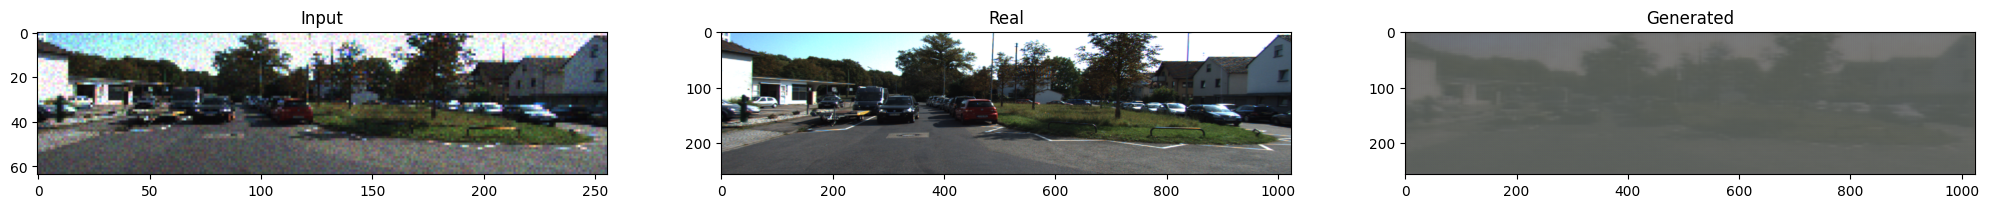

epoch 0  gan_loss: 1.288808822631836  l1_loss: 0.2099427580833435  disc_loss: 2.7932262420654297
-------- psnr:  13.477891    ----- epoch:  1


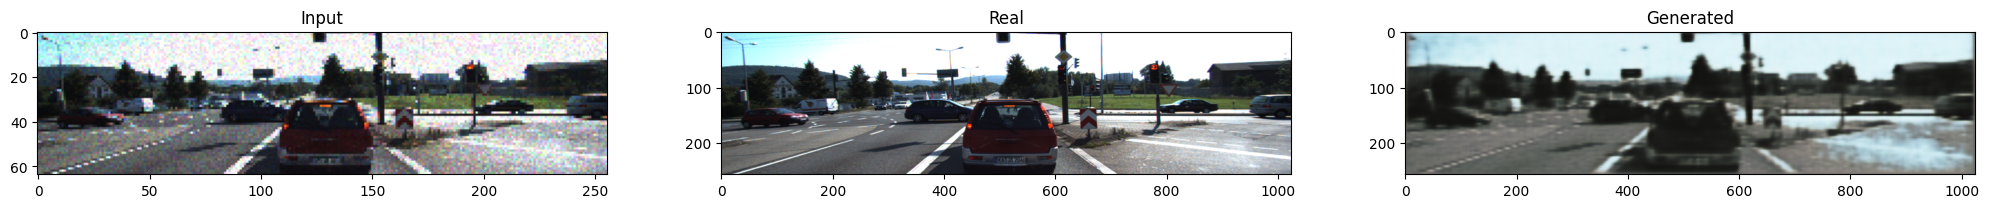

epoch 1  gan_loss: 1.423844814300537  l1_loss: 0.21533644199371338  disc_loss: 2.769282579421997
-------- psnr:  16.275194    ----- epoch:  2


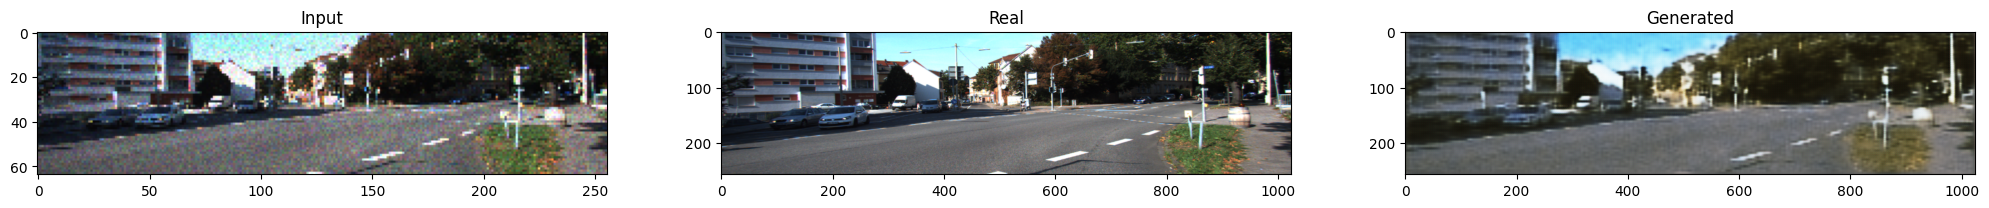

epoch 2  gan_loss: 0.9404479265213013  l1_loss: 0.20387080311775208  disc_loss: 4.602080345153809
-------- psnr:  17.201624    ----- epoch:  3


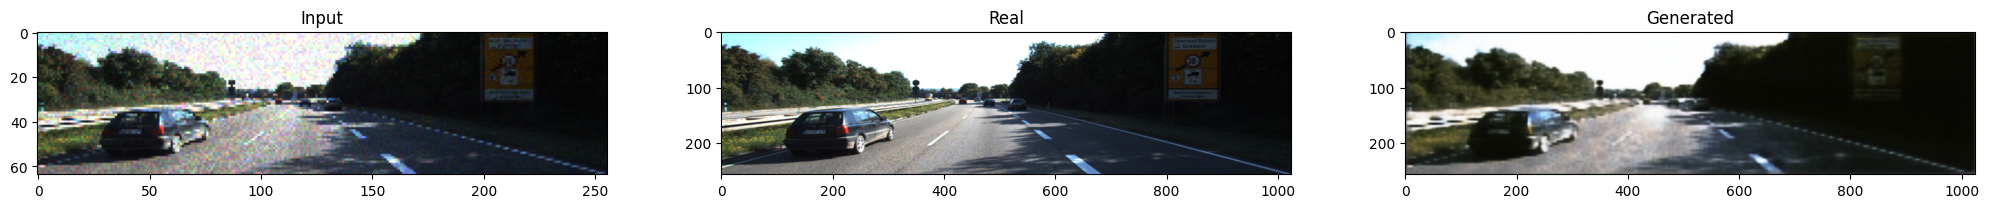

epoch 3  gan_loss: 1.2423357963562012  l1_loss: 0.4082925617694855  disc_loss: 2.7782716751098633
-------- psnr:  15.4964695    ----- epoch:  4
epoch 4  gan_loss: 1.47776198387146  l1_loss: 0.164743572473526  disc_loss: 2.7924060821533203
-------- psnr:  17.320068    ----- epoch:  5


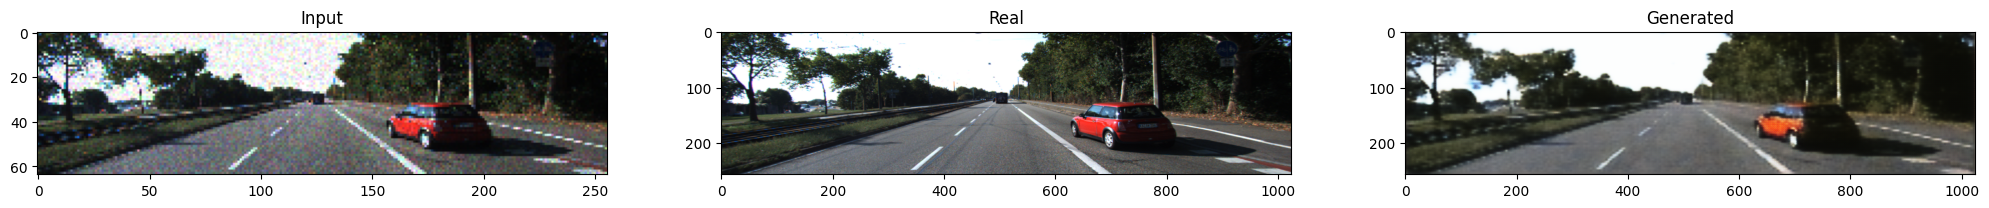

epoch 5  gan_loss: 1.3931277990341187  l1_loss: 0.17412644624710083  disc_loss: 2.7708468437194824
-------- psnr:  16.179499    ----- epoch:  6
epoch 6  gan_loss: 1.3638074398040771  l1_loss: 0.19340136647224426  disc_loss: 2.7774856090545654
-------- psnr:  14.205239    ----- epoch:  7
epoch 7  gan_loss: 1.0883817672729492  l1_loss: 0.7461890578269958  disc_loss: 2.861084222793579
-------- psnr:  14.273363    ----- epoch:  8
epoch 8  gan_loss: 1.4295201301574707  l1_loss: 0.16663898527622223  disc_loss: 2.8092899322509766
-------- psnr:  16.700338    ----- epoch:  9
epoch 9  gan_loss: 1.4467352628707886  l1_loss: 0.21073777973651886  disc_loss: 2.752105236053467
-------- psnr:  15.60696    ----- epoch:  10
epoch 10  gan_loss: 1.6339058876037598  l1_loss: 0.22045443952083588  disc_loss: 2.9507648944854736
-------- psnr:  13.079058    ----- epoch:  11
epoch 11  gan_loss: 1.4536781311035156  l1_loss: 0.8785700798034668  disc_loss: 2.652595043182373
-------- psnr:  12.733298    ----- epoc

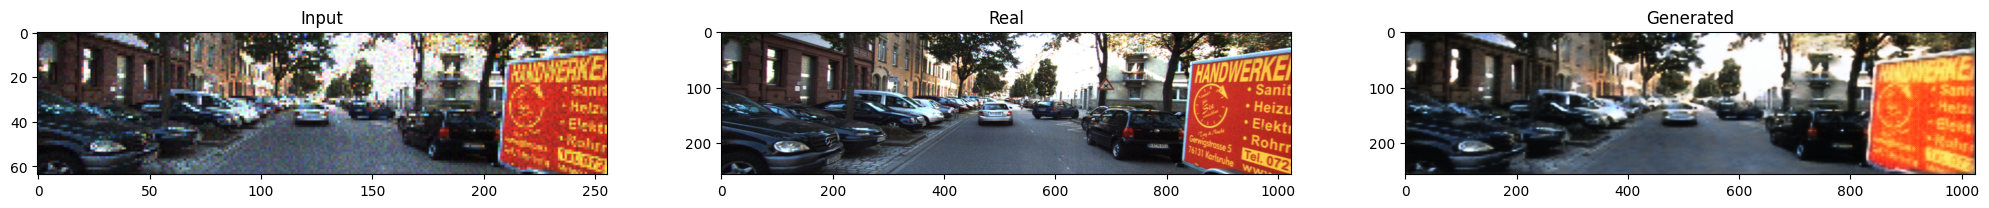

epoch 23  gan_loss: 1.4256947040557861  l1_loss: 0.19068336486816406  disc_loss: 2.746943950653076
-------- psnr:  15.175239    ----- epoch:  24
epoch 24  gan_loss: 1.4558689594268799  l1_loss: 0.1437108814716339  disc_loss: 2.770697593688965
-------- psnr:  16.74659    ----- epoch:  25
epoch 25  gan_loss: 1.3035240173339844  l1_loss: 0.1585131585597992  disc_loss: 2.776552200317383
-------- psnr:  16.115183    ----- epoch:  26
epoch 26  gan_loss: 1.3512728214263916  l1_loss: 0.17857962846755981  disc_loss: 2.7704102993011475
-------- psnr:  15.444808    ----- epoch:  27
epoch 27  gan_loss: 1.388101577758789  l1_loss: 0.18770472705364227  disc_loss: 2.761639356613159
-------- psnr:  15.896654    ----- epoch:  28
epoch 28  gan_loss: 1.3567334413528442  l1_loss: 0.12595689296722412  disc_loss: 2.770146369934082
-------- psnr:  15.98651    ----- epoch:  29
epoch 29  gan_loss: 1.4545607566833496  l1_loss: 0.17860186100006104  disc_loss: 2.765211343765259
-------- psnr:  13.784079    ----- 

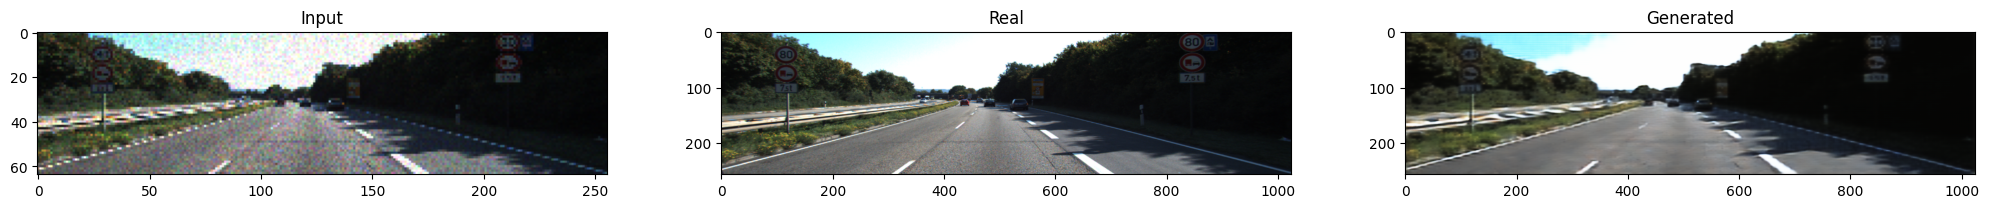

epoch 46  gan_loss: 1.7854869365692139  l1_loss: 0.20654377341270447  disc_loss: 2.6261706352233887
-------- psnr:  15.297711    ----- epoch:  47
epoch 47  gan_loss: 1.4172507524490356  l1_loss: 0.15010124444961548  disc_loss: 2.6692450046539307
-------- psnr:  16.475697    ----- epoch:  48
epoch 48  gan_loss: 1.3838844299316406  l1_loss: 0.13667243719100952  disc_loss: 2.7620935440063477
-------- psnr:  16.19331    ----- epoch:  49
epoch 49  gan_loss: 1.6901543140411377  l1_loss: 0.18293462693691254  disc_loss: 2.721552848815918
-------- psnr:  15.031188    ----- epoch:  50
epoch 50  gan_loss: 1.3984391689300537  l1_loss: 0.15141072869300842  disc_loss: 2.784160852432251
-------- psnr:  12.974716    ----- epoch:  51
epoch 51  gan_loss: 1.3669137954711914  l1_loss: 0.18117961287498474  disc_loss: 2.8246304988861084
-------- psnr:  16.204456    ----- epoch:  52
epoch 52  gan_loss: 1.3057562112808228  l1_loss: 0.1211027055978775  disc_loss: 2.8196401596069336
-------- psnr:  17.425615   

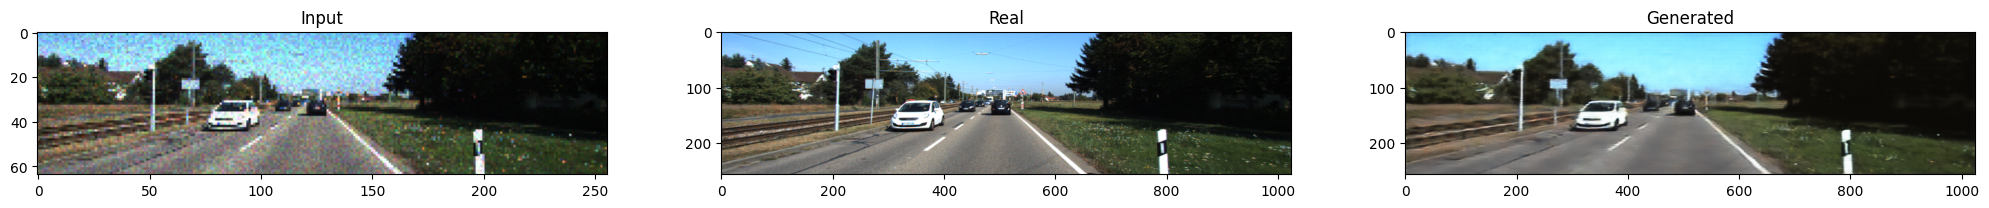

epoch 81  gan_loss: 1.5420091152191162  l1_loss: 0.14325255155563354  disc_loss: 2.857167959213257
-------- psnr:  17.559847    ----- epoch:  82
epoch 82  gan_loss: 1.2284778356552124  l1_loss: 0.1949058175086975  disc_loss: 2.6873557567596436
-------- psnr:  14.563706    ----- epoch:  83
epoch 83  gan_loss: 2.2294363975524902  l1_loss: 0.16618841886520386  disc_loss: 2.620969295501709
-------- psnr:  14.707231    ----- epoch:  84
epoch 84  gan_loss: 1.472182035446167  l1_loss: 0.10699670016765594  disc_loss: 2.7970428466796875
-------- psnr:  14.6538105    ----- epoch:  85
epoch 85  gan_loss: 1.2981818914413452  l1_loss: 0.13119903206825256  disc_loss: 2.9181902408599854
-------- psnr:  15.077441    ----- epoch:  86
epoch 86  gan_loss: 2.1566081047058105  l1_loss: 0.12890011072158813  disc_loss: 3.3679256439208984
-------- psnr:  12.668881    ----- epoch:  87
epoch 87  gan_loss: 1.4831595420837402  l1_loss: 0.1698557287454605  disc_loss: 2.721531629562378
-------- psnr:  15.690136    

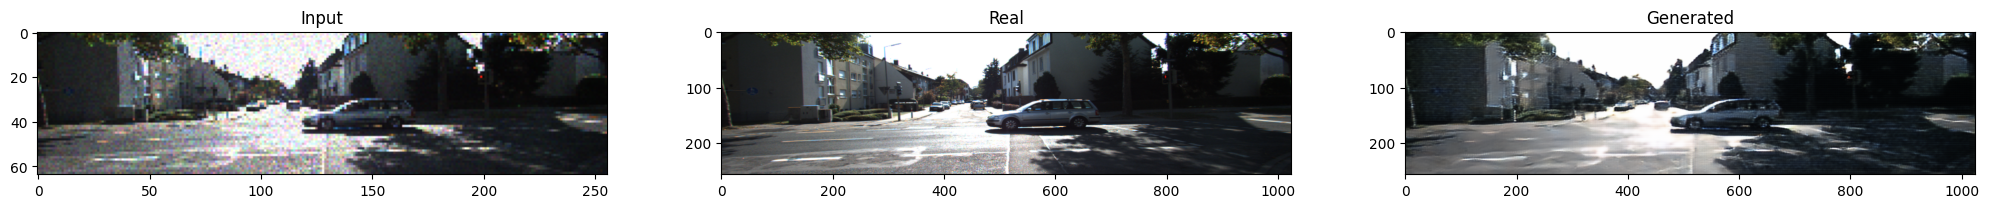

epoch 127  gan_loss: 1.2602522373199463  l1_loss: 0.13473795354366302  disc_loss: 2.783438205718994
-------- psnr:  17.192589    ----- epoch:  128
epoch 128  gan_loss: 1.262507677078247  l1_loss: 0.12977111339569092  disc_loss: 2.699012041091919
-------- psnr:  16.032188    ----- epoch:  129
epoch 129  gan_loss: 1.6319836378097534  l1_loss: 0.11619238555431366  disc_loss: 2.6980106830596924
-------- psnr:  16.384811    ----- epoch:  130
epoch 130  gan_loss: 1.4100732803344727  l1_loss: 0.10576044023036957  disc_loss: 2.808655023574829
-------- psnr:  15.5214    ----- epoch:  131
epoch 131  gan_loss: 1.215646505355835  l1_loss: 0.14418095350265503  disc_loss: 2.7596817016601562
-------- psnr:  14.71121    ----- epoch:  132
epoch 132  gan_loss: 1.4151155948638916  l1_loss: 0.11608003079891205  disc_loss: 2.6754698753356934
-------- psnr:  16.115765    ----- epoch:  133
epoch 133  gan_loss: 1.5108555555343628  l1_loss: 0.11114376038312912  disc_loss: 2.682424545288086
-------- psnr:  16.0

In [11]:
fit(train_dataset, epochs, test_dataset)

In [12]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

In [13]:
generator.save_weights('/kaggle/working/generator.weights.h5')

## Predict

In [14]:
generator.load_weights('/kaggle/working/generator.weights.h5')

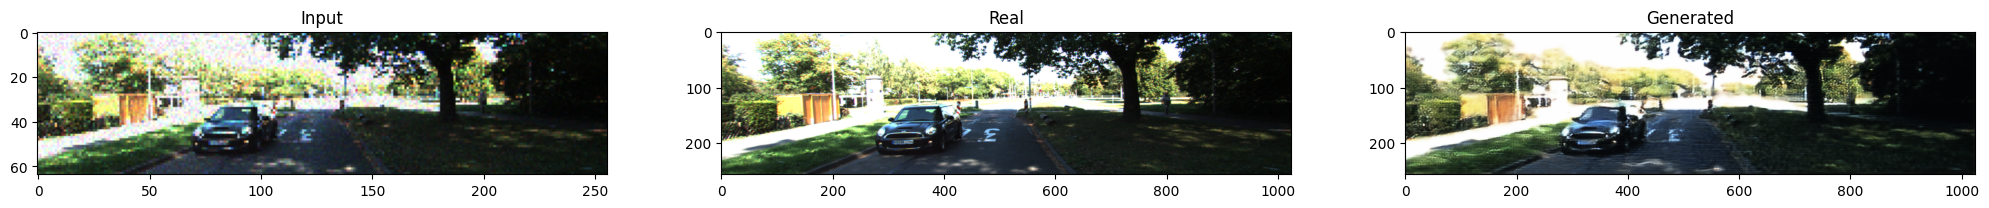

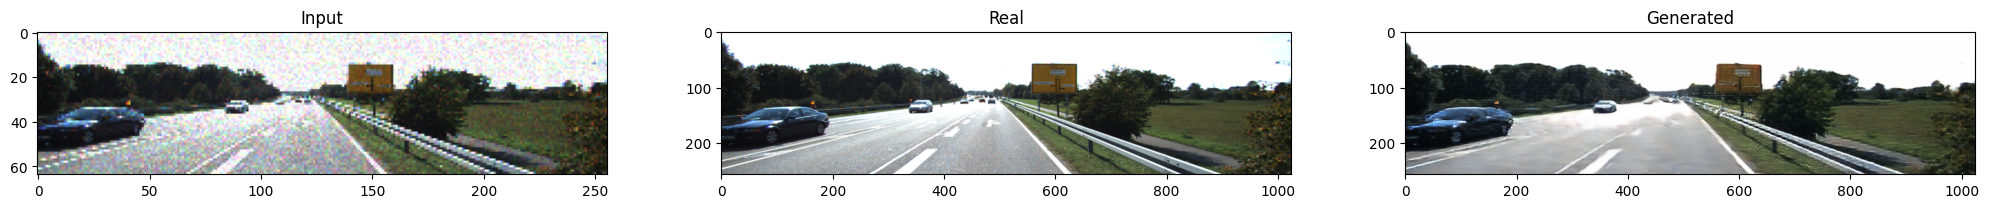

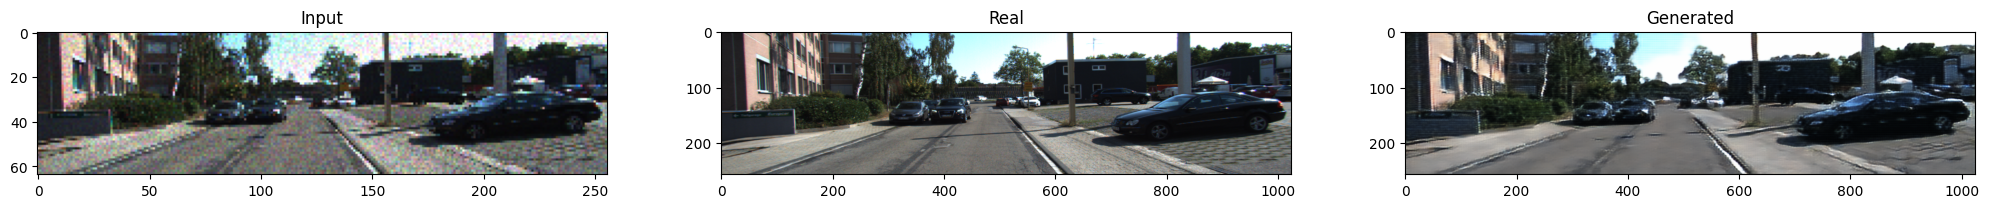

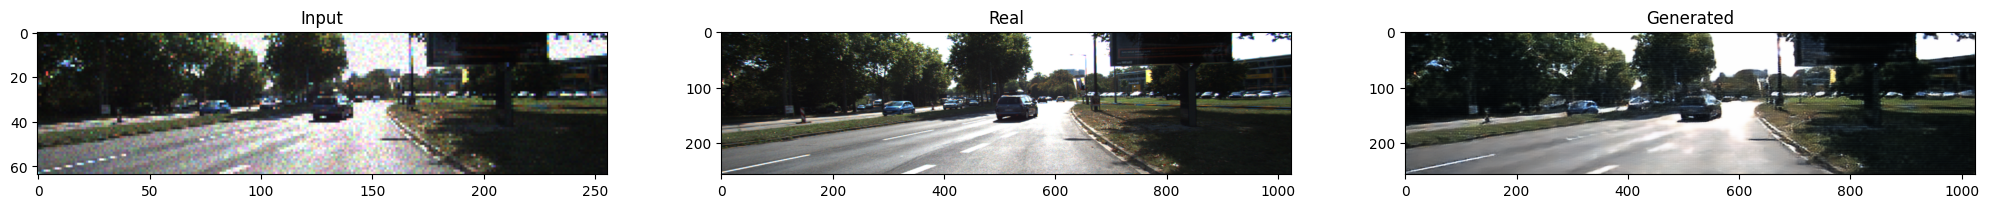

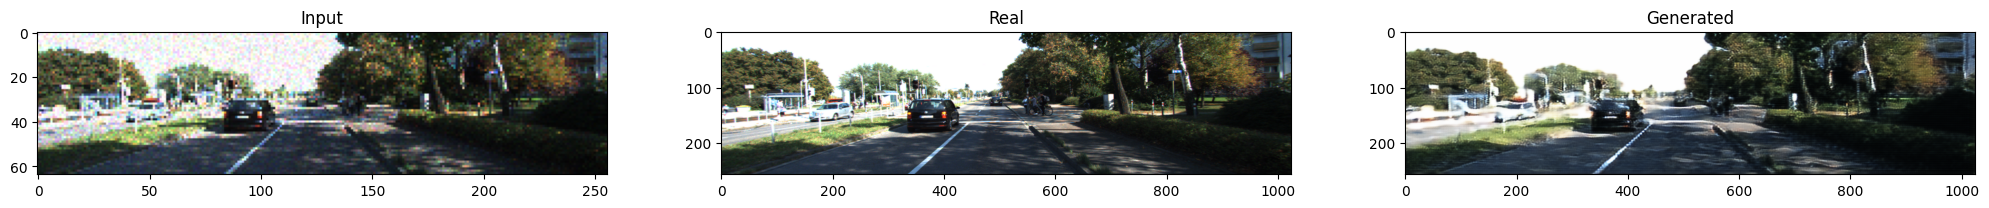

In [15]:
for image_lr, target_lr, target_hr in test_dataset.take(5):
    generate_images(generator, image_lr, target_hr, is_fake_lr=False)